<img src="https://editor.analyticsvidhya.com/uploads/521138.png"> </img>

## VGG-11 is a convolutional neural network that specializes in processing images

## Using VGG-11 to suggest art pieces in a similar style

Given an image that you like, can we suggest pieces in a similar style? Note that this is slightly different than "given an image, can we offer images that look the same"

In [1]:
import torchvision.models as models
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
from skimage import io

In [2]:
# fine tune on style and use bert to vectorize the style name to branch out of style as well??

In [3]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader



device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(torch.backends.mps.is_available())

_transforms = transforms.Compose(
[
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # standardization of pixel colors
])

train_dataset = datasets.ImageFolder(root='/Users/abdelrahmanelbialy/Desktop/deepfashion/output_split/train', transform=_transforms)
test_dataset = datasets.ImageFolder(root='/Users/abdelrahmanelbialy/Desktop/deepfashion/output_split/test', transform=_transforms)

batch_size = 256

training_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

True


In [4]:
#len(train_dataset) + len(test_dataset)
train_dataset.__len__()+test_dataset.__len__()

118437

In [5]:
images, labels = next(iter(training_dataloader)) 
images.shape, labels.shape

(torch.Size([256, 3, 224, 224]), torch.Size([256]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


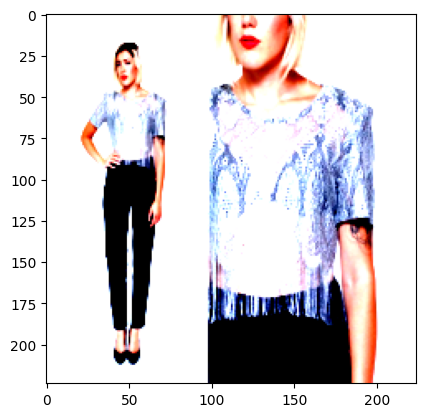

In [6]:
plt.imshow(images[0].detach().numpy().transpose(1, 2, 0))

In [7]:

vgg_model = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
vgg_model.classifier[-1].out_features
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [11]:
vgg_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=46, bias=True)
)

In [9]:
vgg_model.classifier[-1] = nn.Linear(4096 ,46, device='mps')  # Change the final classifier layer to output 10 classes instead of 1,000

for layer in vgg_model.classifier:  # Randomize all parameters in the classifier to start fresh
    if hasattr(layer, 'weight'):  # Randomize all parameters in the classifier to start fresh
        torch.nn.init.xavier_uniform_(layer.weight)  # Randomize all parameters in the classifier to start fresh
    if hasattr(layer, 'bias'):  # Randomize all parameters in the classifier to start fresh
        nn.init.constant_(layer.bias.data, 0)  # Randomize all parameters in the classifier to start fresh

vgg_model.classifier[-1].out_features


46

In [12]:

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(vgg_model.parameters(), lr=0.008, momentum=0.9)

n_epochs = 20 
print_every = 50
valid_loss_min = np.Inf
total_step = len(training_dataloader)

train_loss, val_loss, train_acc, val_acc = [], [], [], [] 


In [13]:
# code inspired from https://www.pluralsight.com/guides/introduction-to-resnet


vgg_model.train()

for epoch in range(1, n_epochs + 1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(training_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        
        optimizer.zero_grad()  # clears the gradient or else they accumulate
        
        outputs = vgg_model(data_)
        
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}%')
    
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        vgg_model.eval()
        for data_t, target_t in (testing_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = vgg_model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _, pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(testing_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}%\n')

        if network_learned:
            valid_loss_min = batch_loss
            torch.save(vgg_model.state_dict(), 'vgg11_4_deepfashion1.pt')
            print('Saving Parameters')
            
    vgg_model.train()
    
# A set device to either cuda or cpu2


Epoch 1

Epoch [1/20], Step [0/371], Loss: 4.8333
Epoch [1/20], Step [50/371], Loss: 2.0445
Epoch [1/20], Step [100/371], Loss: 1.8116
Epoch [1/20], Step [150/371], Loss: 1.5609
Epoch [1/20], Step [200/371], Loss: 1.7942
Epoch [1/20], Step [250/371], Loss: 1.8289
Epoch [1/20], Step [300/371], Loss: 1.6755
Epoch [1/20], Step [350/371], Loss: 1.5213

train-loss: 1.8064, train-acc: 49.0869%
validation loss: 1.5203, validation acc: 55.6502%

Saving Parameters
Epoch 2

Epoch [2/20], Step [0/371], Loss: 1.6783
Epoch [2/20], Step [50/371], Loss: 1.6144
Epoch [2/20], Step [100/371], Loss: 1.2957
Epoch [2/20], Step [150/371], Loss: 1.4545
Epoch [2/20], Step [200/371], Loss: 1.2913
Epoch [2/20], Step [250/371], Loss: 1.3217
Epoch [2/20], Step [300/371], Loss: 1.1911
Epoch [2/20], Step [350/371], Loss: 1.3171

train-loss: 1.5995, train-acc: 59.8628%
validation loss: 1.4230, validation acc: 61.7539%

Saving Parameters
Epoch 3

Epoch [3/20], Step [0/371], Loss: 1.0864
Epoch [3/20], Step [50/371], L

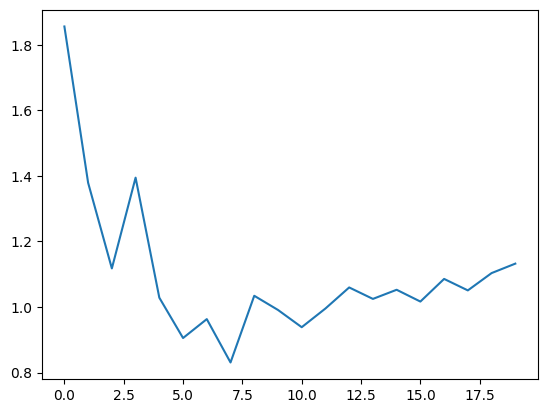

In [54]:
plt.plot(val_loss)

Text(0, 0.5, 'Accuracy %')

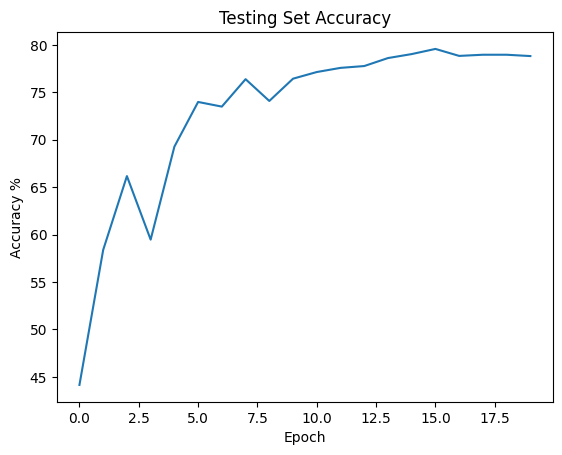

In [56]:
plt.plot(val_acc)
plt.title('Testing Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')

## 2 Weeks Later

In [37]:
# Load up our imports
import torchvision.models as models
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np


In [81]:
# Instantiate a VGG model with our saved weights
vgg_model = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)  # B
vgg_model.classifier[-1] = nn.Linear(4096, 23)
vgg_model.load_state_dict(torch.load('/Users/abdelrahmanelbialy/Desktop/artworksdataset/vgg11_10_wikiart.pt'))

vgg_model.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [58]:
# re-loading the test dataset

batch_size = 32

testing_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [59]:
from tqdm import tqdm

testing_embeddings = torch.zeros(len(test_dataset), 512)
with torch.no_grad():
    for index, (batch, labels) in enumerate(tqdm(testing_dataloader)):
        testing_embeddings[index*batch_size:index*batch_size+batch.shape[0],:] = vgg_model.features(batch).mean((2, 3))
    

ModuleNotFoundError: No module named 'tqdm'

In [17]:
testing_embeddings.shape

torch.Size([16963, 512])

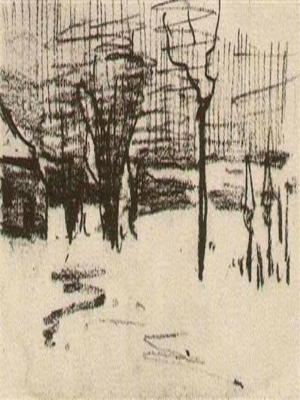

In [89]:
from PIL import Image

img = Image.open('/Users/abdelrahmanelbialy/Desktop/artworksdataset/vincent-van-gogh_garden-in-the-snow-1885(1).jpg')
newsize = (300, 400)
img = img.resize(newsize)
img


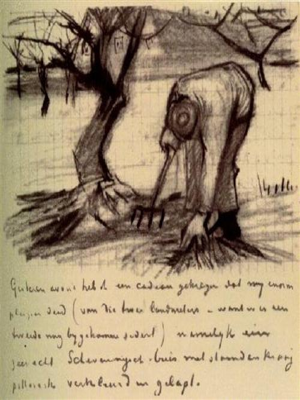

In [90]:
img2 = Image.open('/Users/abdelrahmanelbialy/Desktop/artworksdataset/vincent-van-gogh_gardener-near-a-gnarled-apple-tree-1883(1).jpg')
newsize = (300, 400)
img2 = img2.resize(newsize)
img2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


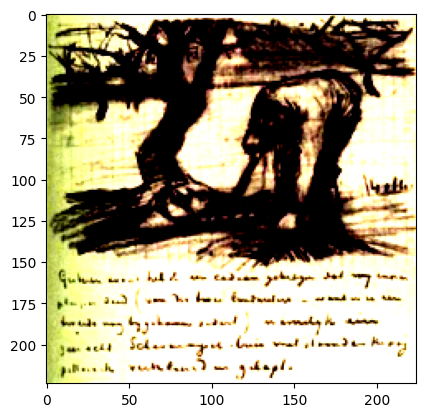

In [91]:
_transforms = transforms.Compose(
[
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # standardization of pixel colors
])

image_matrix = np.asarray(np.expand_dims(_transforms(img), 0))
image2_matrix = np.asarray(np.expand_dims(_transforms(img2), 0))

plt.imshow(image_matrix[0].transpose(1, 2, 0))
plt.imshow(image2_matrix[0].transpose(1, 2, 0))

In [92]:
# style prediction
print(vgg_model(torch.tensor(image_matrix)).argmax())
print(vgg_model(torch.tensor(image2_matrix)).argmax())

tensor(22)
tensor(22)


In [93]:
similarity = torch.cosine_similarity(
    vgg_model.features(torch.tensor(image_matrix)).mean((2, 3)), 
    vgg_model.features(torch.tensor(image2_matrix)).mean((2, 3))
)

print(similarity)


tensor([0.8070], grad_fn=<SumBackward1>)


NameError: name 'top_similar_images' is not defined

<Figure size 640x480 with 0 Axes>

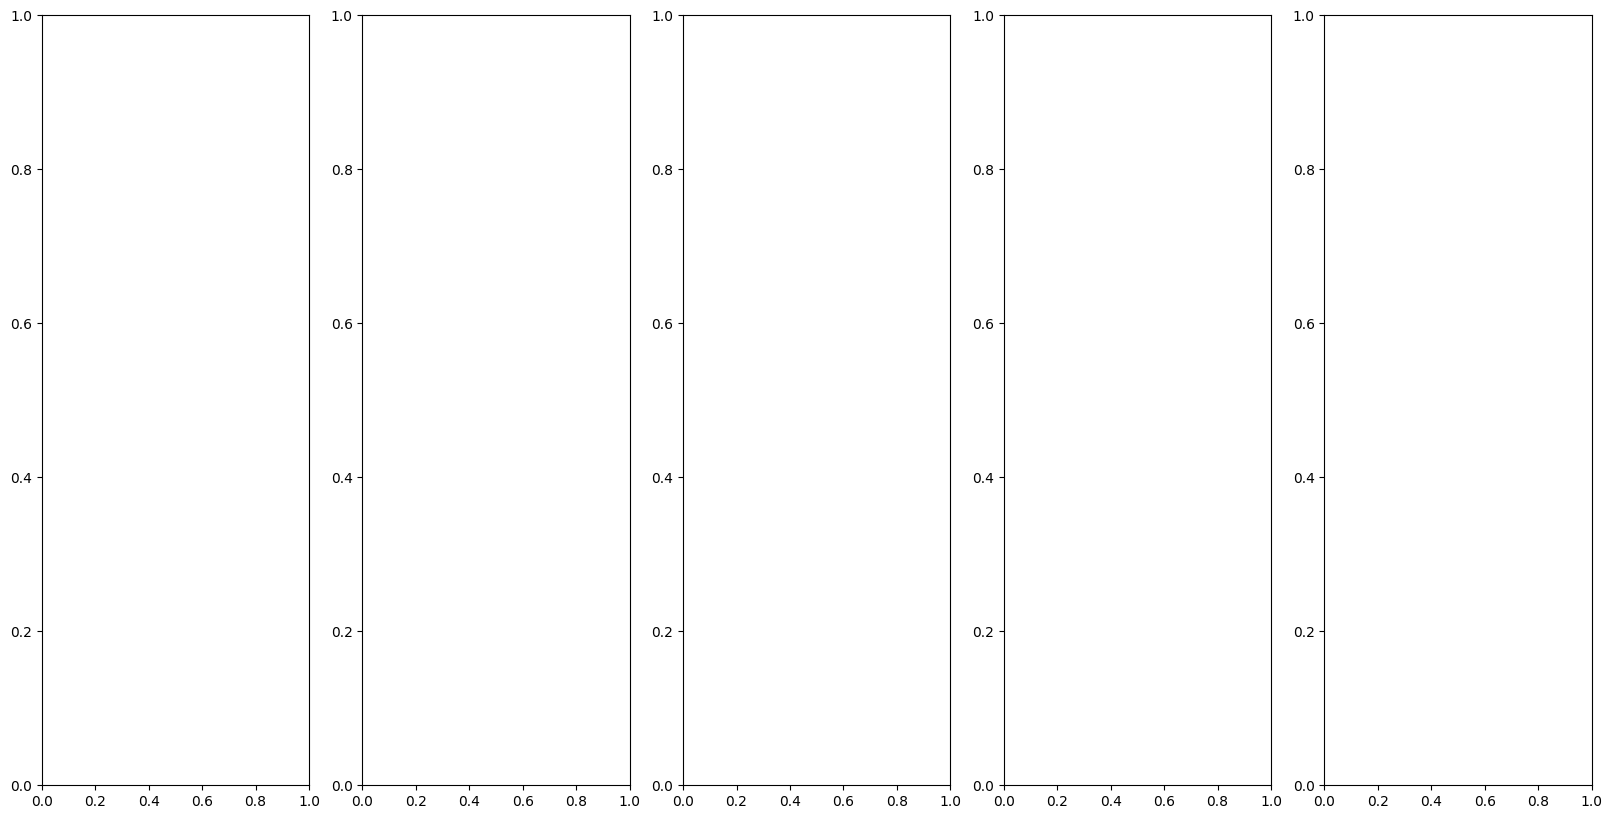

In [17]:
plt.figure()
f, axarr = plt.subplots(1, 5, figsize=(20, 10)) 
for index, top_image in enumerate(top_similar_images):
    axarr[index].imshow(test_dataset[top_image][0].detach().numpy().transpose(1, 2, 0))

# Next Steps + Considersations

1. 100 x 100 is likely not big enough to capture style properly. This was done to make training easier on CPUs
2. It would behoove us to consolidate response to a number closer to 100-300 categories to make training easier
3. We can consider other deep learning models like Resnet and the Vision Transformer
